In [1]:
%pylab inline
#import torch
import pandas as pd
#import pyro
#import pyro.distributions as dist
#import pyro.poutine as poutine
#from pyro.optim import Adam
#from pyro.contrib.autoguide import AutoIAFNormal, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.contrib.brm import defm, makedata
from pyro.contrib.brm.fit import marginals, fitted, summary
#from pyro.contrib.brm.model import parameter_names
from pyro.contrib.brm.pyro_backend import backend as pyro_backend
#from pyro.contrib.brm.design import makedata, predictors, RealValued, Categorical, Integral, dummy_df, make_metadata_lookup
from pyro.contrib.brm.formula import parse
#from pyro.contrib.brm.numpyro_backend import backend as numpyro
from pyro.contrib.brm.backend import data_from_numpy

Populating the interactive namespace from numpy and matplotlib


## Introduction

This notebook demonstrates the use of interactions in model specifications by recreating some of the models, inferences and plots found in the following:

* https://bookdown.org/content/1850/interactions.html
* http://pyro.ai/examples/bayesian_regression.html

## Data

In [2]:
df = pd.read_csv('rugged_data.csv', encoding="ISO-8859-1")
df = df[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df['cont_africa'] = pd.Categorical(df['cont_africa'])
df["log_gdp"] = np.log(df["rgdppc_2000"])
del df['rgdppc_2000']
df0 = df[df['cont_africa'] == 0]
df1 = df[df['cont_africa'] == 1]

In [3]:
df.head()

,cont_africa,rugged,log_gdp
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


## Model

In [4]:
# eqv. to `1 + rugged*cont_africa` (the * operator is not yet supported)
model = defm('log_gdp ~ 1 + rugged + cont_africa + rugged:cont_africa', df)
model

Population
----------------------------------------
Coef Priors:
intercept       | Cauchy(loc=0.0, scale=1.0)
cont_africa[1]  | Cauchy(loc=0.0, scale=1.0)
rugged          | Cauchy(loc=0.0, scale=1.0)
rugged:cont_africa[1] | Cauchy(loc=0.0, scale=1.0)
Response
----------------------------------------
Family: Normal()
Link:
  Parameter: mu
  Function:  identity
Priors:
sigma           | HalfCauchy(scale=3.0)

Here's the design matrix generated by the system for this model/data pair. The columns correspond to the population coefficients mentioned in the model description shown above.

In [5]:
model.data['X'][0:5]

array([[1.   , 1.   , 0.858, 0.858],
       [1.   , 0.   , 3.427, 0.   ],
       [1.   , 0.   , 0.769, 0.   ],
       [1.   , 0.   , 0.775, 0.   ],
       [1.   , 0.   , 2.688, 0.   ]])

## Inference

In [6]:
fit = model.fit(iter=1000)#, backend=numpyro)

sample: 100%|██████████| 1500/1500 [00:34<00:00, 43.85it/s, step size=3.50e-01, acc. prob=0.942]


In [7]:
marginals(fit)

                         mean    sd  2.5%   25%   50%   75% 97.5%
            b_intercept  9.19  0.14  8.90  9.09  9.19  9.28  9.47
       b_cont_africa[1] -1.89  0.23 -2.33 -2.05 -1.88 -1.74 -1.43
               b_rugged -0.19  0.08 -0.34 -0.24 -0.19 -0.14 -0.03
b_rugged:cont_africa[1]  0.37  0.13  0.13  0.28  0.37  0.45  0.64
                  sigma  0.95  0.05  0.86  0.91  0.94  0.98  1.07

## Model Evaluation

In [8]:
# Make a new dataset on which to evaluate the model. This is comprised
# of a series of equally spaced values for ruggedness running from 0 to 6.2 (inclusive).
# This is repeated for both cont_africa=0 and cont_africa=1.
rnge = np.arange(0., 6.3, 0.2)
zeros = np.zeros(len(rnge), dtype=np.int64)
ones = np.ones(len(rnge), dtype=np.int64)
nd = pd.DataFrame(dict(
    rugged=np.hstack((rnge, rnge)),
    cont_africa=pd.Categorical(np.hstack((zeros, ones)))
))
nd.head()

,rugged,cont_africa
0,0.0,0
1,0.2,0
2,0.4,0
3,0.6,0
4,0.8,0


`summary(fitted(fit, data=...))` is analogous to `fitted(fit, newdata=..., summary=TRUE)` in brms.

In [9]:
smry = summary(fitted(fit, data=nd))
#smry.array[0:10] # TODO: It would be good to be able to index this (directly, not via `array`) while retaining the __repr__

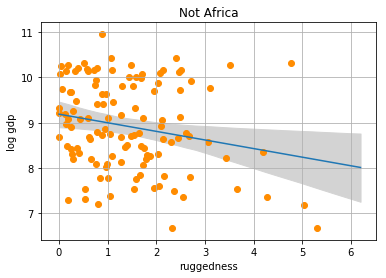

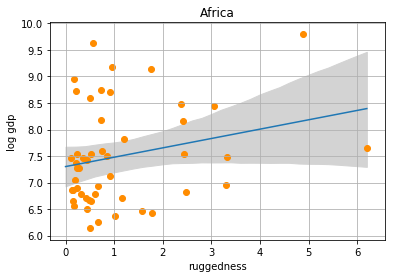

In [10]:
def plot_rugged_vs_log_gdp(fit, cont_africa):
    assert cont_africa in [0, 1]
    # Select either African/other rows from (new/)data and summary.
    data = df[df.cont_africa == cont_africa]      # Original data
    newdata = nd[nd.cont_africa == cont_africa]   # Data used for summary
    s = smry.array[nd.cont_africa == cont_africa] # Summary
    figure()
    title('Africa' if cont_africa == 1 else 'Not Africa')
    xlabel('ruggedness')
    ylabel('log gdp')
    grid()
    mean =  s[:, 0] # mean
    lower = s[:, 2] # 2.5%
    upper = s[:, 6] # 97.5%
    fill_between(newdata['rugged'], lower, upper, color='lightgray')
    plot(newdata['rugged'], mean)
    scatter(data['rugged'], data['log_gdp'], c='darkorange')

plot_rugged_vs_log_gdp(fit, 0)
plot_rugged_vs_log_gdp(fit, 1)